## Performing DA and Control Simulation Experiments (CSE)

##### Loading Python Modules:

In [1]:
import numpy as np
import pickle
import random
import sys
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from class_Lorenz63 import run_RK4
from class_state_vec import state_vector
from class_obs import obs_da
from class_da_sys import da_system
from class_cse import cse

#### Defining lorenz63 model:

In [3]:
sigma = 10.0       # Parameter sigma
rho   = 28.0       # Parameter rho
beta  = 8.0 / 3.0  # Parameter beta

def lorenz63(state, t):
        """
        Calculates the derivatives for the Lorenz63 system.
        
        Parameters:
        state: vector [x, y, z] representing the current state.
        t: current time (not used in Lorenz63 but included for compatibility).
        
        Returns:
        A vector of derivatives [dx/dt, dy/dt, dz/dt].
        """
        x, y, z = state  # Unpack the state vector
        dx = sigma * (y - x)              # Equation for dx/dt
        dy = x * (rho - z) - y            # Equation for dy/dt
        dz = x * y - beta * z             # Equation for dz/dt
        return np.array([dx, dy, dz])     # Return the derivative vector

#### Load the DA system object:

In [4]:
#-----------------------------------------------------------
# Reading da system object:
#-----------------------------------------------------------
name   = 'x_analysis'
infile = name + '_init.pkl'
das    = da_system()
das    = das.load(infile)
#print(das)

#### Initialize the Ensemble:

In [5]:
#-----------------------------------------------------------
# Initializing ensemble:
#-----------------------------------------------------------
xa = das.x0
Xa = das.initEns(xa, mu = das.ens_bias_init, sigma = das.ens_sigma_init, edim = das.edim, separate = 'no')

print('Ensemble dimension: ', das.edim)
print('Initial bias: ', das.ens_bias_init)
print('Initial standard deviation: ', das.ens_sigma_init)
print('xa: ', xa)
print('Xa: ', Xa)


Ensemble dimension:  3
Initial bias:  0
Initial standard deviation:  1.4142135623730951
xa:  [ 8.20747939 10.0860429  23.86324441]
Xa:  [[ 8.84809326  9.35790455  6.41644037]
 [12.87474221  8.01874806  9.36463844]
 [25.42312345 22.95083842 23.21577135]]


#### Get the Nature Run Trajectory:

In [6]:
sv       = das.getStateVector()
x_nature = sv.getTrajectory()

print('x_nature: ', x_nature)

x_nature:  [[ 8.20747939  8.39809589  8.59182394 ... -4.9986383  -4.69976127
  -4.4329259 ]
 [10.0860429  10.31905559 10.5401999  ... -1.85089003 -1.87383032
  -1.92237055]
 [23.86324441 24.07111655 24.31175358 ... 27.47111935 26.83733919
  26.21667603]]


#### Get the observations via the obs_da object:

In [7]:
obs   = das.getObsData()
y_obs = obs.getVal()
y_pos = obs.getPos()
y_err = obs.getErr()

#### Initialize timesteps:

In [8]:
#-----------------------------------------------------------
# Initialize the timesteps:
#-----------------------------------------------------------
t_nature  = sv.getTimes()
acyc_step = das.acyc_step
dtau      = das.dtau
dt_output = das.dt 
fcst_step = das.fcst_dt
fcst_dt   = das.fcst_dt
maxit     = das.maxit
xdim      = das.xdim
ydim      = das.ydim

#print('t_nature: ', t_nature)

#### Choose DA method:

In [9]:
#-----------------------------------------------------------
# Choose DA method:
#-----------------------------------------------------------
method = das.getMethod()
print('Method: ', method)

Method:  EnKF


#### Using same historical data for DA that was used for Qiwen et al., 2022:

In [10]:
#-----------------------------------------------------------
# DO NOT CHANGE THE FOLLOWING LINES:
#-----------------------------------------------------------

''' 

DO NOT CHANGE THE FOLLOWING LINES!!

'''

with open("change_region_time.txt", "rb") as fp:   # Unpickling
    change_region_time = pickle.load(fp)

change_region_time[1]-change_region_time[0]

#########
p = 0
slected_change_region_time = []

for i in range(len(change_region_time)):
    if change_region_time[i] < 500:
        continue
        
    #if change_region_time[i]-change_region_time[i-1] > 337:
    if change_region_time[i]-change_region_time[i-1] > 385:
        slected_change_region_time.append(change_region_time[i])
        #plt.plot(i, change_region_time[i]-change_region_time[i-1], linestyle = 'None', marker = '.')
        p = p + 1
        

#########
t_start_series =[]
for point in slected_change_region_time:
    if point%1 ==0:
        t_start_series.append(point)
        if len(t_start_series)>99:
            break


# Creating evo_history variable:
for t_start in t_start_series[40:41]:
    multiple_number = 4 #this is the  parameter before To in the paper 
    position = int(np.ceil(75.1*multiple_number))
    x_original = x_nature[:,(t_start - position)-(t_start - position)%acyc_step]
    obs_original = y_obs[:,(t_start - position)-(t_start - position)%acyc_step]
    experiment_step = 1000
    evo_history = np.zeros((3,experiment_step*acyc_step+1))
    no_ch_bkp = np.zeros((experiment_step, das.xdim, das.edim))   # change the last dimension
    evo_history[:,0] = x_original


# Create the RK4 solver:
solver = run_RK4(lorenz63, sigma, beta, rho, evo_history[:,0] , 0.01, 80)

# Run the solver:
no_control = solver.run(evo_history[:,0],np.arange(0,80,0.01),np.arange(0,80,0.01))

#### Nature Run + Observations:

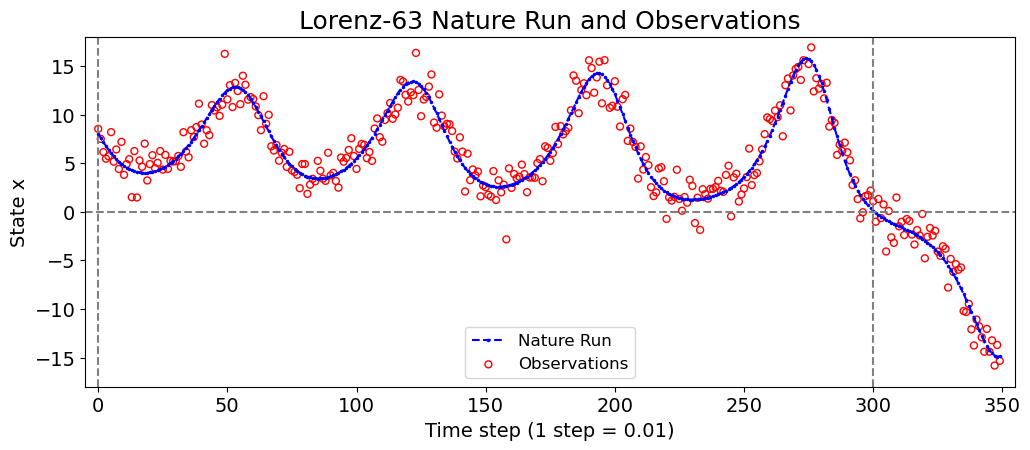

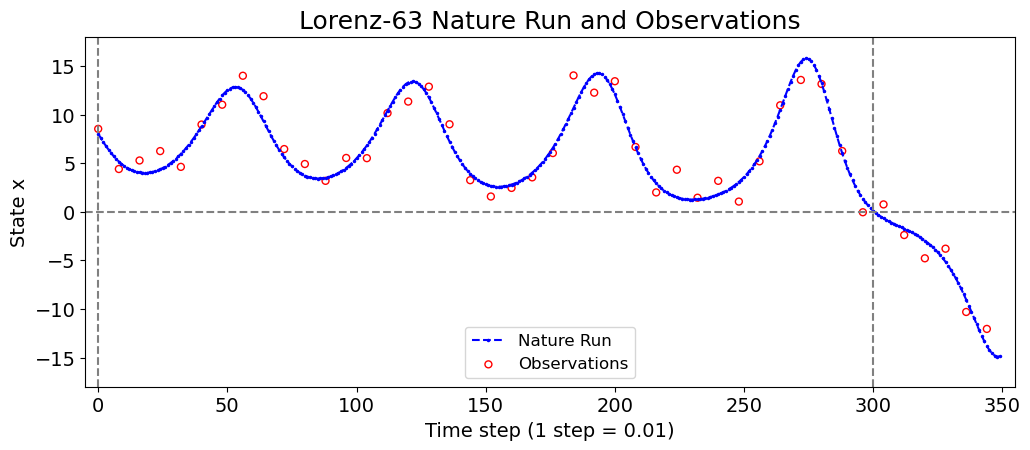

In [11]:
#
# Creating some nice plots:
#
fig = plt.figure(figsize = (12,10))
ax  = fig.add_subplot(211)
plt.plot(x_nature[0,105768:105768+350], linestyle = 'dashed',marker='.', markersize = 3, color = 'blue', label="Nature Run")
plt.scatter(np.arange(350),y_obs[0,105768:105768+350], marker='o', s = 25, facecolors='none', edgecolors='red', label="Observations")
plt.axhline(y=0, linestyle='dashed', color = 'grey')
plt.axvline(x=0, linestyle='dashed', color = 'grey')
plt.axvline(x=300, linestyle='dashed', color = 'grey')
plt.xlabel('Time step (1 step = 0.01)', fontsize = 14)
plt.ylabel('State x', fontsize = 14)
plt.title('Lorenz-63 Nature Run and Observations', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(-18,18)
plt.xlim(-5,350+5)
ax.legend(fontsize=12)
#fig.savefig('Lorenz63_nature_run_observations_without_control_2d_members', bbox_inches = 'tight')

# Plotting observations every 8th time step:
fig = plt.figure(figsize = (12,10))
ax  = fig.add_subplot(211)
plt.plot(x_nature[0,105768:105768+350], linestyle = 'dashed',marker='.', markersize = 3, color = 'blue', label="Nature Run")
plt.scatter(np.arange(0, 350, 8), y_obs[0, 105768:105768+350:8], marker='o', s=25, facecolors='none', edgecolors='red', label="Observations")
plt.axhline(y=0, linestyle='dashed', color = 'grey')
plt.axvline(x=0, linestyle='dashed', color = 'grey')
plt.axvline(x=300, linestyle='dashed', color = 'grey')
plt.xlabel('Time step (1 step = 0.01)', fontsize = 14)
plt.ylabel('State x', fontsize = 14)
plt.title('Lorenz-63 Nature Run and Observations', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(-18,18)
plt.xlim(-5,350+5)
ax.legend(fontsize=12)
fig.savefig('Lorenz63_nature_run_observations_NoControl.png', bbox_inches = 'tight')


### Performing Control Simulation Experiments (CSE):

 * * * Starting the Control Simulation Experiment * * *
 * * * DA update using the observations at time t = 0 * * *
       We choose t = 105768 as the starting time for the control simulation experiment.
yo_all:  [[  8.52310632   7.49195397   6.13944816 ... -15.82349541 -13.70238863
  -15.33848372]
 [  1.5807438    3.8530936    2.31980484 ... -18.70651154 -14.07951845
  -14.65670654]
 [ 31.95505162  29.5658087   30.37102893 ...  33.5091465   38.4118747
   36.29266181]]

 * * * STEP 1: DA update using the observations at time t = 0 * * *
t_index:  0
CSE System Step 1
Method:  EnKF

 * * * STEP 2: RUN ENSEMBLE FORECAST * * *
CSE System Step 2
Position: 301
initial condition forecast: [[ 8.71629577  9.18477686  7.17368814]
 [ 3.69818037  1.49678186  2.20357325]
 [31.64477755 30.55962799 30.62875543]]
xf_4d history:  [[ 8.71629577  3.69818037 31.64477755]
 [ 9.18477686  1.49678186 30.55962799]
 [ 7.17368814  2.20357325 30.62875543]]
CSE System Plot Ensemble Forecast Step 2


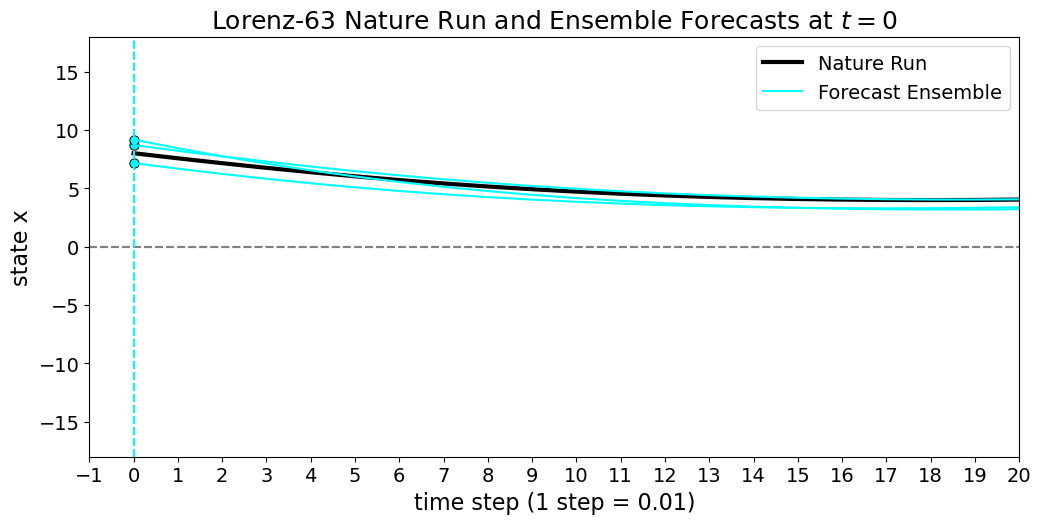

Plotting complete

 * * * STEP 3: CHECKING REGIME SHIFT * * *
CSE System Step 3
Shift predicted by: [1, 2]
Safe ensemble members: [0]
Regime shift detected, activating control.

 * * * STEP 4: CONTROL STEP * * *
CSE System Step 4
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 8.71629577  3.69818037 31.64477755]
 [ 9.18477686  1.49678186 30.55962799]
 [ 7.17368814  2.20357325 30.62875543]]
x_history: [[7.544080107816545, 3.4484391323357233, 30.98718447477377], [7.12641369550053, 3.371297062769317, 30.50402996205134], [6.7592074986579735, 3.330219902799363, 30.026056958939787], [6.438435822518026, 3.319353451589723, 29.555851911474996], [6.160144579307986, 3.3339712829110364, 29.095172300439764], [5.920608054338134, 3.3702951673302284, 28.6452677976582], [5.716356036858542, 3.425380165815008, 28.207072503715104]]
Updated time index: 8

 * * * STEP 5: New NR used to simulate observations at t + Ta * * *
Updated time index: 8
CSE S

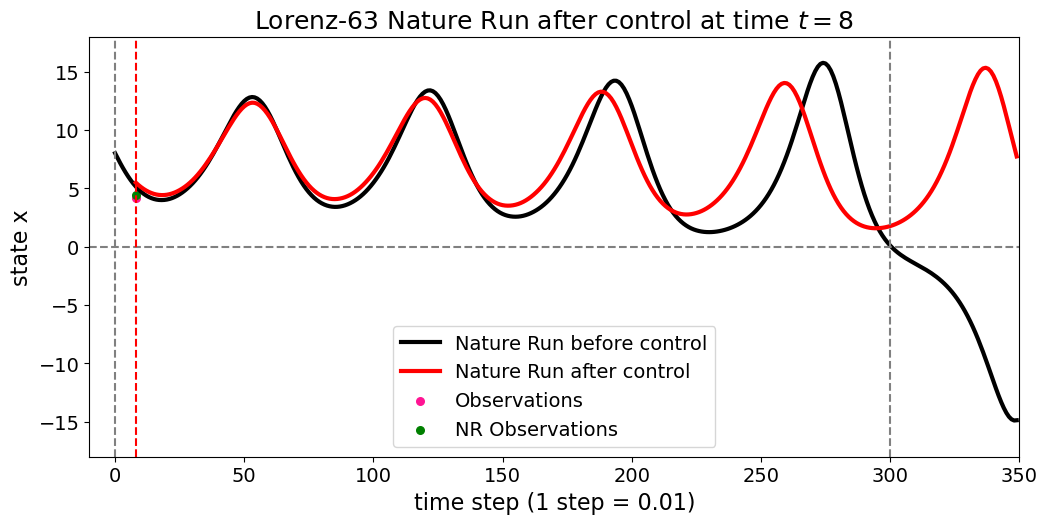

Plotting complete

 * * * STEP 1: DA update using the observations at time t = 0 * * *
t_index:  8
CSE System Step 1
Method:  EnKF

 * * * STEP 2: RUN ENSEMBLE FORECAST * * *
CSE System Step 2
Position: 301
initial condition forecast: [[ 5.80929593  5.32788787  4.79751768]
 [ 3.21349587  2.19588972  2.77626297]
 [27.8496123  26.50441443 26.69568856]]
xf_4d history:  [[ 5.80929593  3.21349587 27.8496123 ]
 [ 5.32788787  2.19588972 26.50441443]
 [ 4.79751768  2.77626297 26.69568856]]
CSE System Plot Ensemble Forecast Step 2


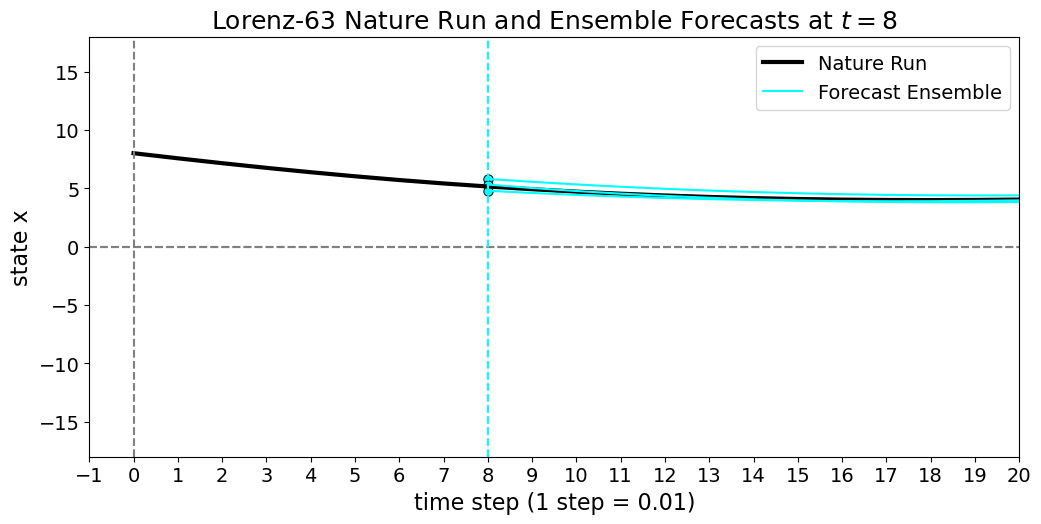

Plotting complete

 * * * STEP 3: CHECKING REGIME SHIFT * * *
CSE System Step 3
Shift predicted by: [1, 2]
Safe ensemble members: [0]
Regime shift detected, activating control.

 * * * STEP 4: CONTROL STEP * * *
CSE System Step 4
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 5.80929593  3.21349587 27.8496123 ]
 [ 5.32788787  2.19588972 26.50441443]
 [ 4.79751768  2.77626297 26.69568856]]
x_history: [[7.617685345245147, 3.36778908298791, 31.015646728526992], [7.244199309403772, 3.2090549505960944, 30.548027889959254], [6.896217628383207, 3.0890613309667603, 30.07364724222604], [6.574006198704607, 3.0043760952193255, 29.596468515586224], [6.277610798727626, 2.951685493091176, 29.119767372015758], [6.006887595639519, 2.927860555024613, 28.646242289008356], [5.7614861490333125, 2.93002824532393, 28.178127634622907]]
Updated time index: 16

 * * * STEP 5: New NR used to simulate observations at t + Ta * * *
Updated time index: 16
C

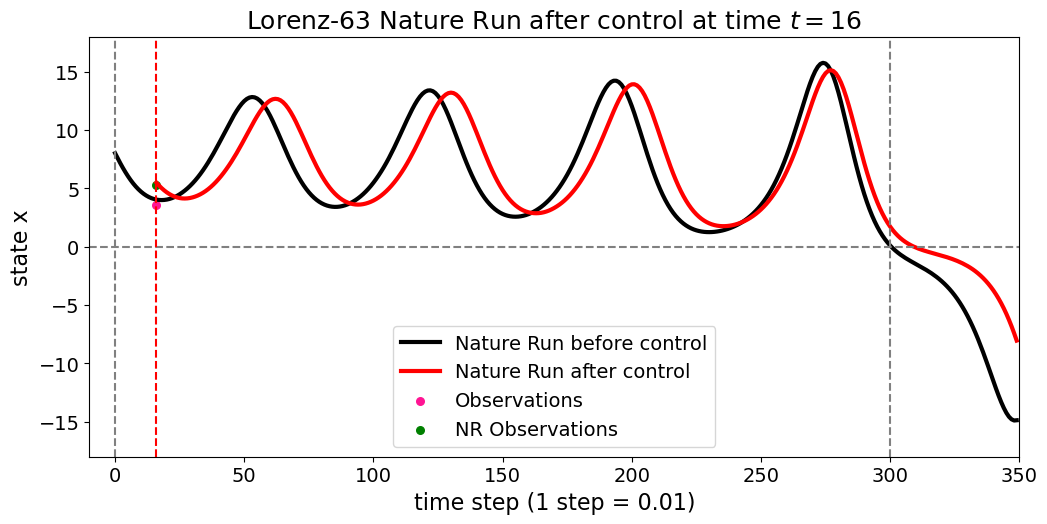

Plotting complete

 * * * STEP 1: DA update using the observations at time t = 0 * * *
t_index:  16
CSE System Step 1
Method:  EnKF

 * * * STEP 2: RUN ENSEMBLE FORECAST * * *
CSE System Step 2
Position: 301
initial condition forecast: [[ 5.17691484  4.72242981  4.92967508]
 [ 5.78912364  5.49395897  5.85877406]
 [22.38632686 21.07576598 21.39366576]]
xf_4d history:  [[ 5.17691484  5.78912364 22.38632686]
 [ 4.72242981  5.49395897 21.07576598]
 [ 4.92967508  5.85877406 21.39366576]]
CSE System Plot Ensemble Forecast Step 2


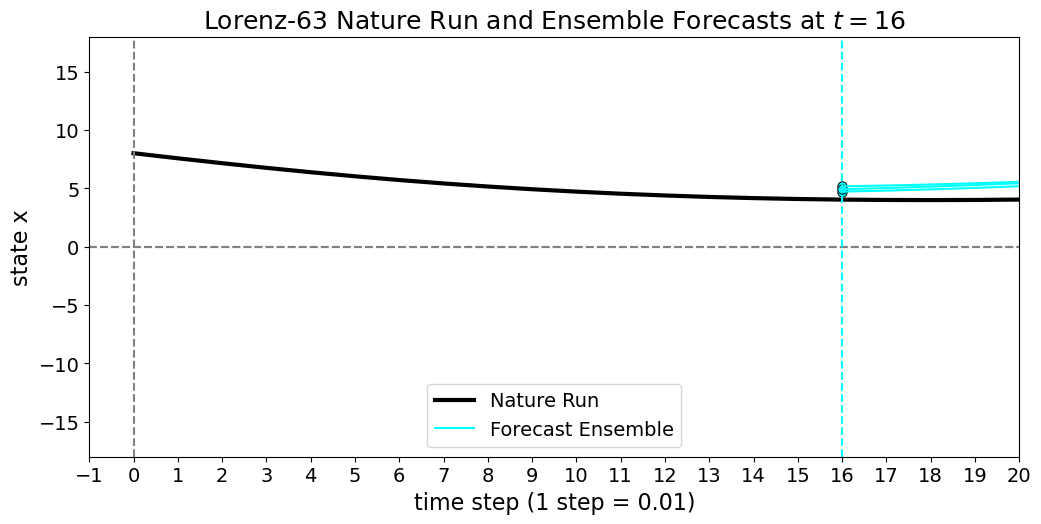

Plotting complete

 * * * STEP 3: CHECKING REGIME SHIFT * * *
CSE System Step 3
Shift predicted by: []
Safe ensemble members: [0, 1, 2]
No regime shift detected. No control applied.
next DA at time t + Ta:  24
Updated time index: 24

 * * * STEP 5: New NR used to simulate observations at t + Ta * * *
Updated time index: 24
CSE System Step 5
Evolve Nature Run 350 - t time steps forward
t_index:  24
350 - t_index:  326
shape np.arange(t_index,350):  (326,)
shape np.arange(t_index,350-t_index):  (302,)
shape np.arange(0, 0.01 * (350 - t_index), 0.01):  (326,)
x_nature_evolved shape:  (326,)
x_nature_evolved:  [ 9.71234174  9.53110042  9.33686932  9.13261786  8.92127491  8.70572883
  8.48883023  8.27338202  8.06178893  7.85619211  7.65854449  7.4706107
  7.29396713  7.13000191  6.97991489  6.84471767  6.7252336   6.62204627
  6.53495899  6.46405608  6.40951974  6.3714488   6.34985866  6.34468132
  6.35576536  6.38287598  6.42569494  6.48382061  6.55676796  6.64364703
  6.74379934  6.857404

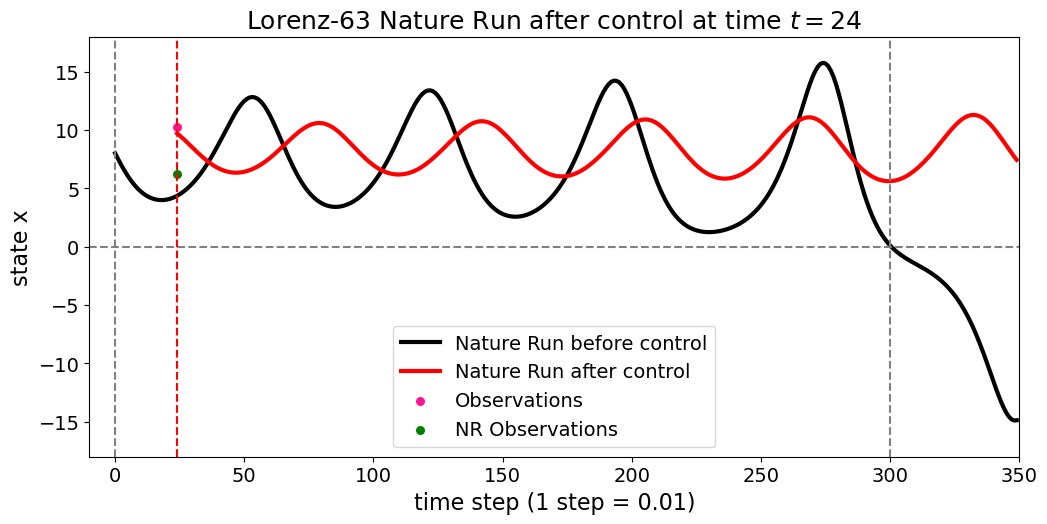

Plotting complete

 * * * STEP 1: DA update using the observations at time t = 0 * * *
t_index:  24
CSE System Step 1
Method:  EnKF

 * * * STEP 2: RUN ENSEMBLE FORECAST * * *
CSE System Step 2
Position: 301
initial condition forecast: [[10.57788672 11.06797738 11.08126608]
 [12.94859409 13.85363142 13.45534659]
 [26.61212397 26.76360017 27.36768642]]
xf_4d history:  [[10.57788672 12.94859409 26.61212397]
 [11.06797738 13.85363142 26.76360017]
 [11.08126608 13.45534659 27.36768642]]
CSE System Plot Ensemble Forecast Step 2


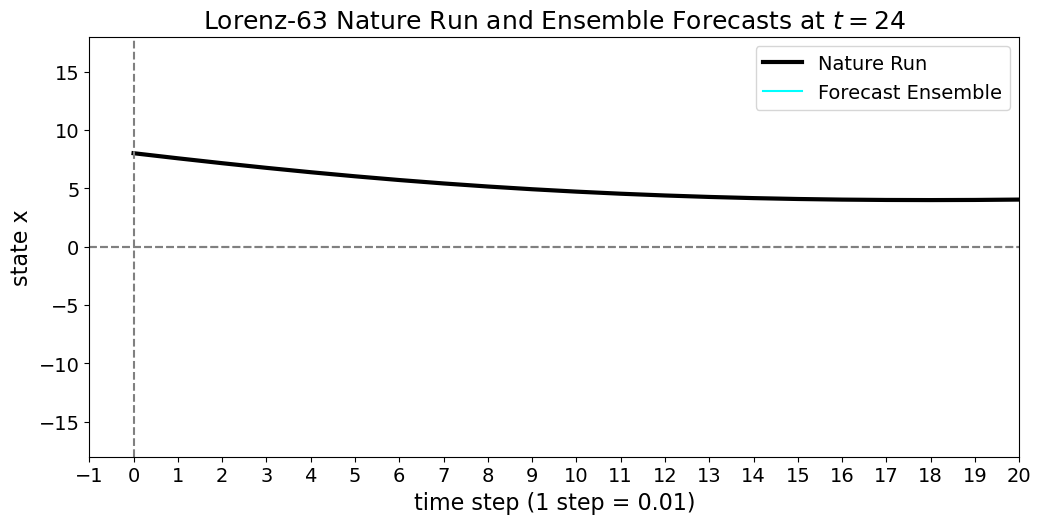

Plotting complete

 * * * STEP 3: CHECKING REGIME SHIFT * * *
CSE System Step 3
Shift predicted by: []
Safe ensemble members: [0, 1, 2]
No regime shift detected. No control applied.
next DA at time t + Ta:  32
Updated time index: 32

 * * * STEP 5: New NR used to simulate observations at t + Ta * * *
Updated time index: 32
CSE System Step 5
Evolve Nature Run 350 - t time steps forward
t_index:  32
350 - t_index:  318
shape np.arange(t_index,350):  (318,)
shape np.arange(t_index,350-t_index):  (286,)
shape np.arange(0, 0.01 * (350 - t_index), 0.01):  (318,)
x_nature_evolved shape:  (318,)
x_nature_evolved:  [ 8.06283598  7.85711655  7.65945626  7.47163785  7.29520294  7.13145209
  6.98152687  6.84630399  6.72629611  6.62193177  6.53356053  6.46145297
  6.40580064  6.36671615  6.3442331   6.3383061   6.34881078  6.37554377
  6.4182171   6.475188    6.54582292  6.63062241  6.72985027  6.84353356
  6.97146264  7.11319114  7.26803593  7.4350772   7.61315838  7.80088619
  7.99663061  8.19852

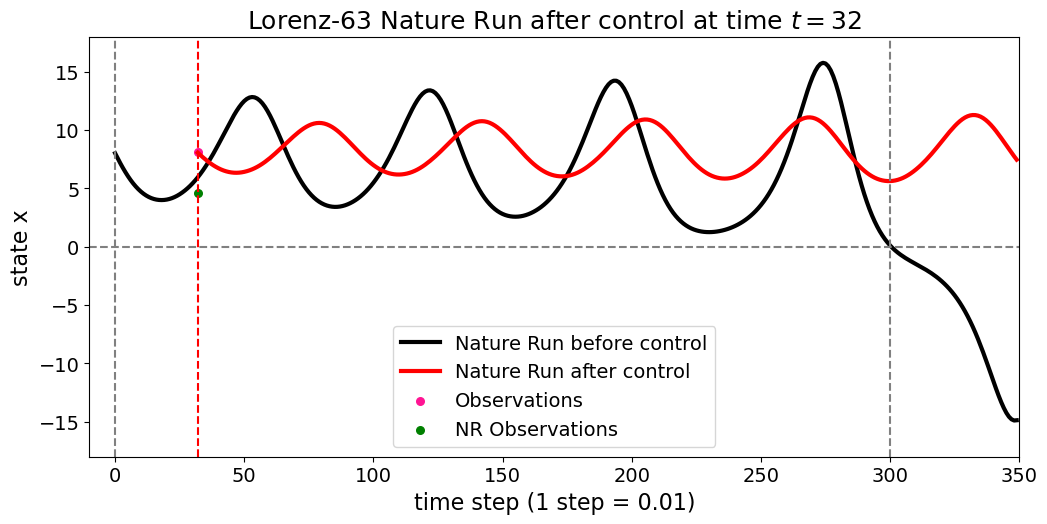

Plotting complete


In [12]:
"""
The Control Simulation Experiment follows these steps:

1. Perform a DA update using the observations at time t = 0.

2. Run an ensemble forecast for T steps from time t to t+T (T = 4 To).

3. If at least one ensemble member shows the regime shift, activate the control (Step 4); otherwise go to Step 1 for the next DA at time t + Ta. Ta = 8 steps.

4. Add perturbations with Euclidean norm D to the NR at every step from t + 1 to t + Ta - 1. At time t + i (i = 1, ..., Ta - 1), the NR
is evolved from the previous NR state at time t + i - 1 and is perturbed by adding (dx, dy, dz), where D = sqrt(dx^2 + dy^2 + dz^2).

5. At time t + Ta, the new NR is used to simulate the observations; go to Step 1 for the next DA at time t + Ta.
"""

print(' * * * Starting the Control Simulation Experiment * * *')
print(' * * * DA update using the observations at time t = 0 * * *')
print('       We choose t = 105768 as the starting time for the control simulation experiment.')


#------------------------------------------------------------
# Defining some useful functions:
#------------------------------------------------------------
# Defining the function to detect regime shifts:
def detect_regime_shift(forecast):
    return np.any(forecast < 0)

# Defining the function to classify ensemble members:
def classify_ensemble(xf_4d):
    predicted_changes = []
    safe_members = []
    for k in range(xf_4d.shape[0]):
        if detect_regime_shift(xf_4d[k, :, 0]):
            predicted_changes.append(k)
        else:
            safe_members.append(k)
    return predicted_changes, safe_members

# Defining the function to compute perturbation vector:
def compute_perturbation(xf_safe, xf_shift, D):
    delta = xf_safe - xf_shift
    return delta / (np.linalg.norm(delta) * D)

# Defining the function to evolve nature with control:
def evolve_nature_with_control(x_init, perturb_vec, solver, steps):
    x = x_init.copy()
    history = []
    for q in range(steps):
        x_perturbed = x + perturb_vec[q, :]
        x_next = solver.run(x_perturbed, np.arange(0, 0.015, 0.01), np.arange(0, 0.015, 0.01))[1, :]
        history.append(x_perturbed)
        x = x_next
    return x, history


#-----------------------------------------------------------
# Initializing ensemble:
#-----------------------------------------------------------
das.x0   = x_nature[:,105768]        # initial condition (time = 105768)
xa       = das.x0
Xa       = das.initEns(xa, mu = das.ens_bias_init, sigma = das.ens_sigma_init, edim = das.edim, separate = 'no')

#-----------------------------------------------------------
# Get observations:
#-----------------------------------------------------------
obs.setVal(y_obs[:,105768])
yo = obs.getVal()
yo_all = y_obs[:,105768:105768+350]
print('yo_all: ', yo_all)

#--------------------------------------------------------------------
# CREATE HISTORY OF ENSEMBLE FORECAST:
# Run a long ensemble forecast for 8000 time steps.
#--------------------------------------------------------------------
position   = 8000
Xf_history = np.zeros((das.edim, position, das.xdim))
Xf         = Xa.copy()

# Create the RK4 solver:
solver = run_RK4(lorenz63, sigma, beta, rho, np.ravel(Xf[:,0]), 0.01, 0.01 * position)

# Run forecast for each ensemble member, using the initial condition from the posterior ensemble:
for k in range(das.edim):
    xf_ens = solver.run(np.ravel(Xa[:,k]),np.arange(0,0.01 * position,0.01),np.arange(0,0.01 * position,0.01))
    Xf_history[k,:,:] = xf_ens

#--------------------------------------------------------------------
#
# Starting DA cycle:
#
#--------------------------------------------------------------------
Xf            = Xa.copy()
xf_4d_history = []          # Initialize the history of ensemble forecast
cse_system    = cse()
t_index       = 0
Ta            = 8
num_cycles    = 2
t_final       = Ta


while t_index < Ta*4:
#while t_index < Ta*20:
    #----------------------------------------------
    # STEP 1: PERFORM DA UPDATE:
    #----------------------------------------------
    print('\n * * * STEP 1: DA update using the observations at time t = 0 * * *')
    print('t_index: ', t_index)
    #Xf         = Xa.copy()
    #cse_system = cse()
    Xa, KH     = cse_system.CSE_Step1(Xf, yo, das)
    #--------------------------------------------------------------------
    # STEP 2: RUN ENSEMBLE FORECAST:
    # Run an ensemble forecast for T steps from time t to t+T (T = 4 To).
    #--------------------------------------------------------------------
    print('\n * * * STEP 2: RUN ENSEMBLE FORECAST * * *')
    multiple_number = 4       # This is the  parameter before To in the paper 
    T_0 = 75.1
    # Create the RK4 solver:
    solver = run_RK4(lorenz63, sigma, beta, rho, np.ravel(Xf[:,0]), 0.01, 0.01 * position)
    # Run forecast for each ensemble member, using the initial condition from the posterior ensemble:
    xf_4d  = cse_system.CSE_Step2(multiple_number, T_0, solver, Xa, das)
    #print(f'Ensemble forecast shape: {xf_4d.shape}')
    #print(f'Ensemble forecast at time t_index {t_index}: {xf_4d}')
    xf_4d_history.append(xf_4d[:,0,:].copy())  # Save the ensemble forecast history
    cse_system.history = xf_4d_history.copy()  # Save the history of ensemble forecast
    print('xf_4d history: ', xf_4d[:,0,:])
    # Plotting the ensemble forecast:
    cse_system.t_index = t_index
    cse_system.Plot_Ensemble_Fcst_Step2(x_nature, xf_4d, Xa, t_index, T_0, multiple_number)
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 3: REGIME SHIFT: Checking regime shift
    #------------------------------------------------------------------------------------------------------------------------------------
    print('\n * * * STEP 3: CHECKING REGIME SHIFT * * *')
    predicted_changes, safe_members = cse_system.CSE_Step3(xf_4d)
    print(f'Shift predicted by: {predicted_changes}')
    print(f'Safe ensemble members: {safe_members}')
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 4: CONTROL STEP: If regime shift is detected, activate the control. Otherwise, go to Step 1 for the next DA at time t + Ta.
    #------------------------------------------------------------------------------------------------------------------------------------
    if len(predicted_changes) > 0:
        print('Regime shift detected, activating control.')
        print('\n * * * STEP 4: CONTROL STEP * * *')
        D = 0.05   # Euclidean norm
        x_final , kk = cse_system.CSE_Step4(predicted_changes, safe_members, xf_4d, x_original, solver, Ta, D, das)
        #print(f'Final state after control: {x_final}')
    else:
        print('No regime shift detected. No control applied.')
        print('next DA at time t + Ta: ', t_index + Ta)
        x_final = x_nature[:,t_index+Ta]
    # Update time index for the next DA cycle:
    t_index += Ta
    print(f'Updated time index: {t_index}')
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 5: Simulate new observations; go to Step 1 for the next DA at time t + Ta.:
    #------------------------------------------------------------------------------------------------------------------------------------
    print('\n * * * STEP 5: New NR used to simulate observations at t + Ta * * *')
    print(f'Updated time index: {t_index}')
    yo_new = cse_system.CSE_Step5(x_final, das)
    # Plotting new NR and observations:
    cse_system.Plot_New_NR_and_Obs(x_final, x_nature, yo_new, yo_all, t_index, Ta, solver, das)
    # Update observations for the next DA cycle
    yo = yo_new.copy()
    Xf = xf_4d[:, t_index, :].copy().T
    #------------------------------------------------------------------------------------------------------------------------------------

## Performing CSE Experiments (NO PLOTS):

In [12]:
"""
The Control Simulation Experiment follows these steps:

1. Perform a DA update using the observations at time t = 0.

2. Run an ensemble forecast for T steps from time t to t+T (T = 4 To).

3. If at least one ensemble member shows the regime shift, activate the control (Step 4); otherwise go to Step 1 for the next DA at time t + Ta. Ta = 8 steps.

4. Add perturbations with Euclidean norm D to the NR at every step from t + 1 to t + Ta - 1. At time t + i (i = 1, ..., Ta - 1), the NR
is evolved from the previous NR state at time t + i - 1 and is perturbed by adding (dx, dy, dz), where D = sqrt(dx^2 + dy^2 + dz^2).

5. At time t + Ta, the new NR is used to simulate the observations; go to Step 1 for the next DA at time t + Ta.
"""

print(' * * * Starting the Control Simulation Experiment * * *')
print(' * * * DA update using the observations at time t = 0 * * *')
print('       We choose t = 105768 as the starting time for the control simulation experiment.')


#------------------------------------------------------------
# Defining some useful functions:
#------------------------------------------------------------
# Defining the function to detect regime shifts:
def detect_regime_shift(forecast):
    return np.any(forecast < 0)

# Defining the function to classify ensemble members:
def classify_ensemble(xf_4d):
    predicted_changes = []
    safe_members = []
    for k in range(xf_4d.shape[0]):
        if detect_regime_shift(xf_4d[k, :, 0]):
            predicted_changes.append(k)
        else:
            safe_members.append(k)
    return predicted_changes, safe_members

# Defining the function to compute perturbation vector:
def compute_perturbation(xf_safe, xf_shift, D):
    delta = xf_safe - xf_shift
    return delta / (np.linalg.norm(delta) * D)

# Defining the function to evolve nature with control:
def evolve_nature_with_control(x_init, perturb_vec, solver, steps):
    x = x_init.copy()
    history = []
    for q in range(steps):
        x_perturbed = x + perturb_vec[q, :]
        x_next = solver.run(x_perturbed, np.arange(0, 0.015, 0.01), np.arange(0, 0.015, 0.01))[1, :]
        history.append(x_perturbed)
        x = x_next
    return x, history


#-----------------------------------------------------------
# Initializing ensemble:
#-----------------------------------------------------------
das.x0   = x_nature[:,105768]        # initial condition (time = 105768)
xa       = das.x0
Xa       = das.initEns(xa, mu = das.ens_bias_init, sigma = das.ens_sigma_init, edim = das.edim, separate = 'no')

#-----------------------------------------------------------
# Get observations:
#-----------------------------------------------------------
obs.setVal(y_obs[:,105768])
yo = obs.getVal()

#--------------------------------------------------------------------
# CREATE HISTORY OF ENSEMBLE FORECAST:
# Run a long ensemble forecast for 8000 time steps.
#--------------------------------------------------------------------
position   = 8000
Xf_history = np.zeros((das.edim, position, das.xdim))
Xf         = Xa.copy()

# Create the RK4 solver:
solver = run_RK4(lorenz63, sigma, beta, rho, np.ravel(Xf[:,0]), 0.01, 0.01 * position)

# Run forecast for each ensemble member, using the initial condition from the posterior ensemble:
for k in range(das.edim):
    xf_ens = solver.run(np.ravel(Xa[:,k]),np.arange(0,0.01 * position,0.01),np.arange(0,0.01 * position,0.01))
    Xf_history[k,:,:] = xf_ens



#--------------------------------------------------------------------
#
# Starting DA cycle:
#
#--------------------------------------------------------------------
Xf               = Xa.copy()
xf_4d_history    = []          # Initialize the history of ensemble forecast
x_nature_control = []          # Initialize the history of nature run with control
cse_system       = cse()
t_index          = 0
Ta               = 8
num_cycles       = 49
t_final          = Ta
x_original       = evo_history[:,0].copy()  # Initial condition for the control simulation

while t_index < num_cycles*Ta:
    #----------------------------------------------
    # STEP 1: PERFORM DA UPDATE:
    #----------------------------------------------
    print('\n * * * STEP 1: DA update using the observations at time t = 0 * * *')
    print('t_index: ', t_index)
    Xa, KH     = cse_system.CSE_Step1(Xf, yo, das)
    #--------------------------------------------------------------------
    # STEP 2: RUN ENSEMBLE FORECAST:
    # Run an ensemble forecast for T steps from time t to t+T (T = 4 To).
    #--------------------------------------------------------------------
    print('\n * * * STEP 2: RUN ENSEMBLE FORECAST * * *')
    multiple_number = 4       # This is the  parameter before To in the paper 
    T_0 = 75.1
    # Create the RK4 solver:
    solver = run_RK4(lorenz63, sigma, beta, rho, np.ravel(Xf[:,0]), 0.01, 0.01 * position)
    # Run forecast for each ensemble member, using the initial condition from the posterior ensemble:
    xf_4d  = cse_system.CSE_Step2(multiple_number, T_0, solver, Xa, das)
    xf_4d_history.append(xf_4d[:,0,:].copy())  # Save the ensemble forecast history
    cse_system.history = xf_4d_history.copy()  # Save the history of ensemble forecast
    # Plotting the ensemble forecast:
    cse_system.t_index = t_index
    #cse_system.Plot_Ensemble_Fcst_Step2(x_nature, xf_4d, Xa, t_index, T_0, multiple_number)
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 3: REGIME SHIFT: Checking regime shift
    #------------------------------------------------------------------------------------------------------------------------------------
    print('\n * * * STEP 3: CHECKING REGIME SHIFT * * *')
    predicted_changes, safe_members = cse_system.CSE_Step3(xf_4d)
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 4: CONTROL STEP: If regime shift is detected, activate the control. Otherwise, go to Step 1 for the next DA at time t + Ta.
    #------------------------------------------------------------------------------------------------------------------------------------
    if len(predicted_changes) > 0:
        print('Regime shift detected, activating control.')
        print('\n * * * STEP 4: CONTROL STEP * * *')
        D = 0.05   # Euclidean norm
        x_final, x_final_history = cse_system.CSE_Step4(predicted_changes, safe_members, xf_4d, x_original, solver, Ta, D, das)
    else:
        print('No regime shift detected. No control applied.')
        print('next DA at time t + Ta: ', t_index + Ta)
        x_final, x_history = cse_system.CSE_Step3b(xf_4d, x_original, solver, Ta, D, das)
        #x_final_history = x_history[1:,0]  # Save the final state history without control
        x_final_history = x_history  # Save the final state history without control
        #x_final = x_nature[:,t_index+Ta]
    print(f'Final state after control: {x_final}')
    #print('shape of x_history: ', np.shape(x_history))
    #print('x_history: ', x_history[1:,0])
    print(f'Final state history after control: {x_final_history}')
    print(f'shape of x_final_history: {np.shape(x_final_history)}')
    x_original = x_final.copy()  # Update the original state for the next cycle
    x_nature_control.extend(x_final_history.copy())  # Save the nature run with control])
    t_index += Ta
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 5: Simulate new observations; go to Step 1 for the next DA at time t + Ta.:
    #------------------------------------------------------------------------------------------------------------------------------------
    print('\n * * * STEP 5: New NR used to simulate observations at t + Ta * * *')
    print(f'Updated time index: {t_index}')
    yo_new = cse_system.CSE_Step5(x_final, das)
    # Plotting new NR and observations:
    #cse_system.Plot_New_NR_and_Obs(x_final, x_nature, yo_new, t_index, Ta, solver, das)
    # Update observations for the next DA cycle
    yo = yo_new.copy()
    print(f'shape xf_4d: {xf_4d.shape}')
    print(f't_index: {t_index}')
    #Xf = xf_4d[:, t_index, :].copy().T
    Xf = xf_4d[:, Ta, :].copy().T
    #------------------------------------------------------------------------------------------------------------------------------------

 * * * Starting the Control Simulation Experiment * * *
 * * * DA update using the observations at time t = 0 * * *
       We choose t = 105768 as the starting time for the control simulation experiment.

 * * * STEP 1: DA update using the observations at time t = 0 * * *
t_index:  0
CSE System Step 1
Method:  EnKF

 * * * STEP 2: RUN ENSEMBLE FORECAST * * *
CSE System Step 2
Position: 301
initial condition forecast: [[ 8.71629577  9.18477686  7.17368814]
 [ 3.69818037  1.49678186  2.20357325]
 [31.64477755 30.55962799 30.62875543]]

 * * * STEP 3: CHECKING REGIME SHIFT * * *
CSE System Step 3
Regime shift detected, activating control.

 * * * STEP 4: CONTROL STEP * * *
CSE System Step 4
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 8.71629577  3.69818037 31.64477755]
 [ 9.18477686  1.49678186 30.55962799]
 [ 7.17368814  2.20357325 30.62875543]]
x_history: [[7.544080107816545, 3.4484391323357233, 30.98718447477377], [7.1264136

## Plotting the results:

In [13]:
x_nature_nocontrol = x_nature[0,105768:105768+350].copy()
x_nature_control = np.asarray(x_nature_control)

print('x_nature_nocontrol: ', x_nature_nocontrol[0:num_cycles*Ta], np.shape(x_nature_nocontrol[0:num_cycles*Ta]))
print('x_nature_control_full: ', x_nature_control, np.shape(x_nature_control))

x_nature_nocontrol:  [  8.01616968   7.5793716    7.15993667   6.76131441   6.38638217
   6.03744514   5.71623636   5.42391671   5.1610749    4.92745677
   4.72193366   4.54384543   4.39249546   4.26712077   4.16689202
   4.09091349   4.0382231    4.0077924    3.99837946   4.00928171
   4.04051866   4.09205179   4.16377496   4.25551448   4.36702901
   4.49800966   4.64807993   4.81679571   5.00378734   5.20991094
   5.43597329   5.68244504   5.94955189   6.23727459   6.54534895
   6.87326581   7.22027106   7.58536565   7.96729761   8.36394994
   8.77295612   9.19149226   9.61583559  10.04136457  10.46255876
  10.87299896  11.26536707  11.63144621  11.96218371  12.25136577
  12.4906242   12.67102175  12.78583124  12.83053561  12.80282785
  12.70261107  12.53199846  12.29491546  11.99311065  11.63370296
  11.22555214  10.77756488  10.2986948    9.79794248   9.28435541
   8.76702806   8.25497584   7.75532056   7.27326422   6.81321859
   6.37883373   5.97299797   5.59783794   5.25471854   

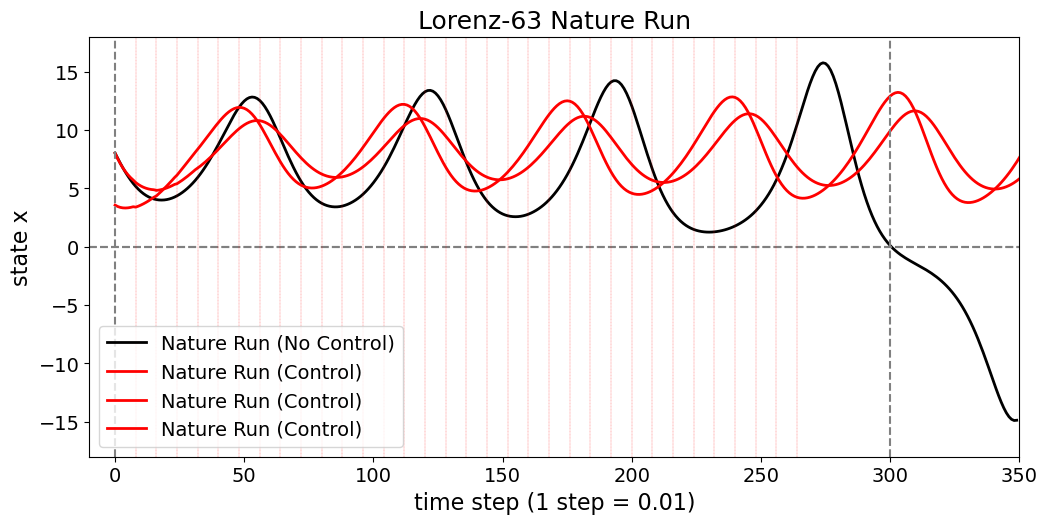

Plotting complete


In [14]:
fig = plt.figure(figsize = (12,12))
ax  = fig.add_subplot(211)
plt.plot(x_nature_nocontrol[0:num_cycles*Ta+1], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'black', label="Nature Run (No Control)")
plt.plot(x_nature_control, linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'red', label="Nature Run (Control)")
plt.axhline(y = 0, linestyle='dashed', color = 'grey')   
plt.axhline(y = 0, linestyle='dashed', color = 'grey')
plt.axvline(x = 0, linestyle='dashed', color = 'grey')
for x in np.arange(8, 8*34, 8):
	plt.axvline(x=x, linestyle='dashed', linewidth=0.2, color='red')
plt.axvline(x = 300, linestyle='dashed', color = 'grey')
plt.xlabel('time step (1 step = 0.01)', fontsize = 16)
plt.ylabel('state x', fontsize = 16)
plt.title('Lorenz-63 Nature Run', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(-18,18)
plt.xlim(-10,350)
ax.legend(fontsize=14)
plt.show()
#fig.savefig('Forecasts_Step2_Time_Step_'+str(t_index)+'.png', dpi=300, bbox_inches = 'tight')
plt.close(fig)
print('Plotting complete')
        

#### Running Control Simulation Experiments (CSE) with 1000 iterations:

 * * * Starting the Control Simulation Experiment * * *
 * * * DA update using the observations at time t = 0 * * *
       We choose t = 105768 as the starting time for the control simulation experiment.

 * * * STEP 1: DA update using the observations at time t = 0 * * *
t_index:  0
CSE System Step 1
Method:  EnKF
Xa: [[ 8.71629577  9.18477686  7.17368814]
 [ 3.69818037  1.49678186  2.20357325]
 [31.64477755 30.55962799 30.62875543]]

 * * * STEP 2: RUN ENSEMBLE FORECAST * * *
CSE System Step 2
Position: 301
initial condition forecast: [[ 8.71629577  9.18477686  7.17368814]
 [ 3.69818037  1.49678186  2.20357325]
 [31.64477755 30.55962799 30.62875543]]
initial condition xf_4d[:,0,:]: [[ 8.71629577  3.69818037 31.64477755]
 [ 9.18477686  1.49678186 30.55962799]
 [ 7.17368814  2.20357325 30.62875543]]

 * * * STEP 3: CHECKING REGIME SHIFT * * *
CSE System Step 3
Regime shift detected, activating control.

 * * * STEP 4: CONTROL STEP * * *
CSE System Step 4
At least one ensemble member sh

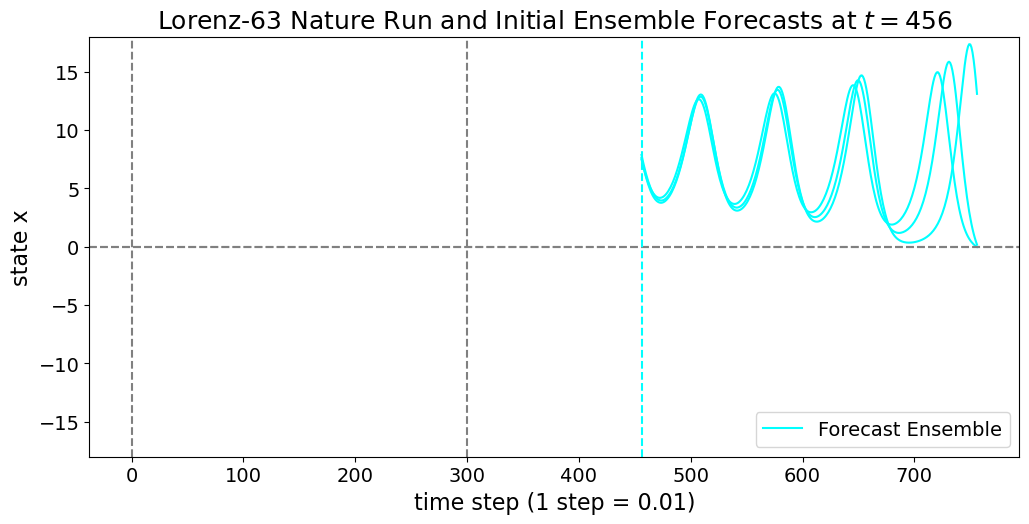

Plotting complete
  STEP 3: Detecting regime shift ensemble members...
CSE System Step 3
  Shift predicted by: [0]
  Safe ensemble members: [1, 2]
  Found safe ensemble members after 1 time steps.
t_index:  464
t_index_incr:  8
t_index_shifted:  456
  STEP 4: Applying control...
  initial condition shift xf_4d[:,0,:]: [[ 7.4770631   3.43330317 30.57869034]
 [ 7.86365183  3.4467083  31.31231748]
 [ 7.60692908  3.09820387 31.15957233]]
 ttt: 293
 safe_idx: 1
 t_index_incr: 8
shape xf_4d: (3, 301, 3)
  xf_shift shape: (293, 3)
kk shape:  (200,)
  xf_safe shape: (293, 3)
Computing perturbation vector...
  x_history: [[6.166853456321642, 3.889068037759127, 27.47113539813752], [5.322631243179426, 3.750260325121356, 25.86201276002123], [4.5982141656892885, 3.7553096498175202, 24.26439438632467], [3.9958391649565685, 3.8739530649283687, 22.69503877397541], [3.5142573897426805, 4.082413560891094, 21.165676996883395], [3.149735350791236, 4.363584167084813, 19.684799955431643], [2.897127204781117

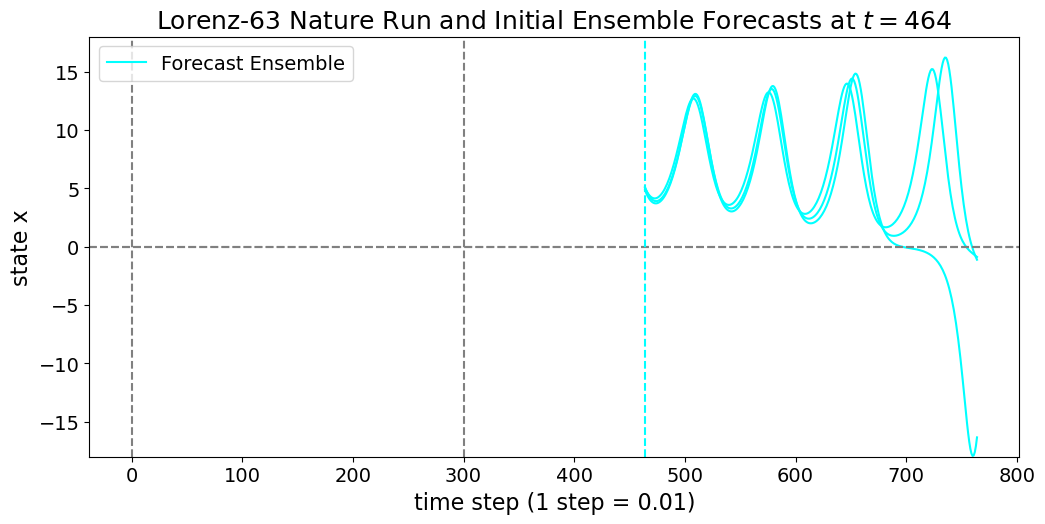

Plotting complete
  STEP 3: Detecting regime shift ensemble members...
CSE System Step 3
  Shift predicted by: [0, 1, 2]
  Safe ensemble members: []
  No safe ensemble members found after 1 time steps. Continuing to search.
self.history shape: (59, 8, 3)
history_arr: [[ 7.4770631   3.43330317 30.57869034]
 [ 7.86365183  3.4467083  31.31231748]
 [ 7.60692908  3.09820387 31.15957233]]
history_current: [[ 4.15159203  4.0169449  22.19510318]
 [ 3.95925698  3.55138528 22.49911112]
 [ 3.75735708  3.41459775 22.1609637 ]]
history_arr shape: (3, 3)
  STEP 2: Running ensemble forecast with time shift: 2
CSE System Step 2
Position: 301
initial condition forecast: [[ 7.4770631   7.86365183  7.60692908]
 [ 3.43330317  3.4467083   3.09820387]
 [30.57869034 31.31231748 31.15957233]]
  xf_4d shape: (3, 301, 3)
  initial condition xf_4d[:,8,:].T: [[ 5.00409297  5.0641      4.80916783]
 [ 2.97519069  2.64971159  2.45560766]
 [26.02046802 26.57989275 26.28737185]]
  initial condition xf_4d[:,8,:]: [[ 5.

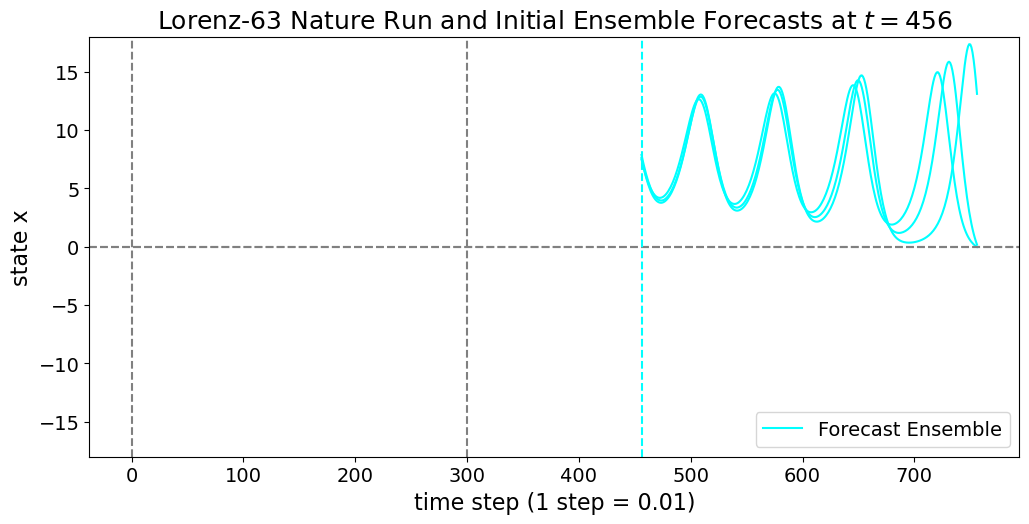

Plotting complete
  STEP 3: Detecting regime shift ensemble members...
CSE System Step 3
  Shift predicted by: [0]
  Safe ensemble members: [1, 2]
  Found safe ensemble members after 2 time steps.
t_index:  472
t_index_incr:  16
t_index_shifted:  456
  STEP 4: Applying control...
  initial condition shift xf_4d[:,0,:]: [[ 7.4770631   3.43330317 30.57869034]
 [ 7.86365183  3.4467083  31.31231748]
 [ 7.60692908  3.09820387 31.15957233]]
 ttt: 285
 safe_idx: 1
 t_index_incr: 16
shape xf_4d: (3, 301, 3)
  xf_shift shape: (285, 3)
kk shape:  (200,)
  xf_safe shape: (285, 3)
Computing perturbation vector...
  x_history: [[2.850391222832943, 5.253796810582399, 16.62354642719668], [2.715435462971723, 5.614810813167091, 15.373697916312876], [2.6733327571773726, 6.037997710119823, 14.179534173840398], [2.7212868059205664, 6.527358327479217, 13.049087525061895], [2.8569943981104426, 7.09008902625941, 11.990909988492815], [3.0789068025746915, 7.736203289669815, 11.01464239007734], [3.3865040411787

In [18]:
"""
The Control Simulation Experiment follows these steps:

1. Perform a DA update using the observations at time t = 0.

2. Run an ensemble forecast for T steps from time t to t+T (T = 4 To).

3. If at least one ensemble member shows the regime shift, activate the control (Step 4); otherwise go to Step 1 for the next DA at time t + Ta. Ta = 8 steps.

4. Add perturbations with Euclidean norm D to the NR at every step from t + 1 to t + Ta - 1. At time t + i (i = 1, ..., Ta - 1), the NR
is evolved from the previous NR state at time t + i - 1 and is perturbed by adding (dx, dy, dz), where D = sqrt(dx^2 + dy^2 + dz^2).

5. At time t + Ta, the new NR is used to simulate the observations; go to Step 1 for the next DA at time t + Ta.
"""

print(' * * * Starting the Control Simulation Experiment * * *')
print(' * * * DA update using the observations at time t = 0 * * *')
print('       We choose t = 105768 as the starting time for the control simulation experiment.')


#------------------------------------------------------------
# Defining some useful functions:
#------------------------------------------------------------
# Defining the function to detect regime shifts:
def detect_regime_shift(forecast):
    return np.any(forecast < 0)

# Defining the function to classify ensemble members:
def classify_ensemble(xf_4d):
    predicted_changes = []
    safe_members = []
    for k in range(xf_4d.shape[0]):
        if detect_regime_shift(xf_4d[k, :, 0]):
            predicted_changes.append(k)
        else:
            safe_members.append(k)
    return predicted_changes, safe_members

# Defining the function to compute perturbation vector:
def compute_perturbation(xf_safe, xf_shift, D):
    delta = xf_safe - xf_shift
    return delta / (np.linalg.norm(delta) * D)

# Defining the function to evolve nature with control:
def evolve_nature_with_control(x_init, perturb_vec, solver, steps):
    x = x_init.copy()
    history = []
    for q in range(steps):
        x_perturbed = x + perturb_vec[q, :]
        x_next = solver.run(x_perturbed, np.arange(0, 0.015, 0.01), np.arange(0, 0.015, 0.01))[1, :]
        history.append(x_perturbed)
        x = x_next
    return x, history


#-----------------------------------------------------------
# Initializing ensemble:
#-----------------------------------------------------------
das.x0   = x_nature[:,105768]        # initial condition (time = 105768)
xa       = das.x0
Xa       = das.initEns(xa, mu = das.ens_bias_init, sigma = das.ens_sigma_init, edim = das.edim, separate = 'no')

#-----------------------------------------------------------
# Get observations:
#-----------------------------------------------------------
obs.setVal(y_obs[:,105768])
yo = obs.getVal()

#--------------------------------------------------------------------
# CREATE HISTORY OF ENSEMBLE FORECAST:
# Run a long ensemble forecast for 8000 time steps.
#--------------------------------------------------------------------
position   = 8000
Xf_history = np.zeros((das.edim, position, das.xdim))
Xf         = Xa.copy()

# Create the RK4 solver:
solver = run_RK4(lorenz63, sigma, beta, rho, np.ravel(Xf[:,0]), 0.01, 0.01 * position)

# Run forecast for each ensemble member, using the initial condition from the posterior ensemble:
for k in range(das.edim):
    xf_ens = solver.run(np.ravel(Xa[:,k]),np.arange(0,0.01 * position,0.01),np.arange(0,0.01 * position,0.01))
    Xf_history[k,:,:] = xf_ens



#--------------------------------------------------------------------
#
# Starting DA cycle:
#
#--------------------------------------------------------------------
Xf               = Xa.copy()
xf_4d_history    = []          # Initialize the history of ensemble forecast
x_nature_control = []          # Initialize the history of nature run with control
cse_system       = cse()
t_index          = 0
Ta               = 8
num_cycles       = 60
t_final          = Ta
x_original       = evo_history[:,0].copy()  # Initial condition for the control simulation

while t_index < num_cycles*Ta:
    #----------------------------------------------
    # STEP 1: PERFORM DA UPDATE:
    #----------------------------------------------
    print('\n * * * STEP 1: DA update using the observations at time t = 0 * * *')
    print('t_index: ', t_index)
    Xa, KH     = cse_system.CSE_Step1(Xf, yo, das)
    #print(f'Xf: {Xf}')
    print(f'Xa: {Xa}')
    if t_index > 0:
       #cse_system.Plot_Ensemble_Fcst_Step5(x_nature, x_nature_control[-8:], xf_4d[:, 0:Ta+1, :], Xa, yo, t_index, T_0, multiple_number) 
       print(f'Xa after DA update: {Xa}')
       print(f'yo after DA update: {yo}')
       print(f'Xf before DA update: {Xf}')
    #--------------------------------------------------------------------
    # STEP 2: RUN ENSEMBLE FORECAST:
    # Run an ensemble forecast for T steps from time t to t+T (T = 4 To).
    #--------------------------------------------------------------------
    print('\n * * * STEP 2: RUN ENSEMBLE FORECAST * * *')
    multiple_number = 4       # This is the  parameter before To in the paper 
    T_0 = 75.1
    # Create the RK4 solver:
    solver = run_RK4(lorenz63, sigma, beta, rho, np.ravel(Xf[:,0]), 0.01, 0.01 * position)
    # Run forecast for each ensemble member, using the initial condition from the posterior ensemble:
    xf_4d  = cse_system.CSE_Step2(multiple_number, T_0, solver, Xa, das)
    print(f'initial condition xf_4d[:,0,:]: {xf_4d[:,0,:]}')
    xf_4d_history.append(xf_4d[:,0,:].copy())  # Save the ensemble forecast history
    cse_system.history = xf_4d_history.copy()  # Save the history of ensemble forecast
    cse_system.xf4d = xf_4d.copy()  # Save the ensemble forecast for plotting
    # Plotting the ensemble forecast:
    cse_system.t_index = t_index
    #cse_system.Plot_Ensemble_Fcst_Step2(x_nature, xf_4d, Xa, t_index, T_0, multiple_number)
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 3: REGIME SHIFT: Checking regime shift
    #------------------------------------------------------------------------------------------------------------------------------------
    print('\n * * * STEP 3: CHECKING REGIME SHIFT * * *')
    predicted_changes, safe_members = cse_system.CSE_Step3(xf_4d)
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 4: CONTROL STEP: If regime shift is detected, activate the control. Otherwise, go to Step 1 for the next DA at time t + Ta.
    #------------------------------------------------------------------------------------------------------------------------------------
    if len(predicted_changes) > 0:
        print('Regime shift detected, activating control.')
        print('\n * * * STEP 4: CONTROL STEP * * *')
        D = 0.05   # Euclidean norm
        x_final, x_final_history = cse_system.CSE_Step4(predicted_changes, safe_members, xf_4d, x_original, solver, Ta, D, das)
        #cse_system.Plot_Ensemble_Fcst_Step2(x_nature, xf_4d, Xa, t_index, T_0, multiple_number)
        #print(f'Regime shift detected. Final state after control: {x_final}')
        #print(f'Regime shift detected. Final history state after control: {x_final_history}')
        #break
    else:
        print('No regime shift detected. No control applied.')
        print('next DA at time t + Ta: ', t_index + Ta)
        x_final, x_history = cse_system.CSE_Step3b(xf_4d, x_original, solver, Ta, D, das)
        x_final_history = x_history  # Save the final state history without control
        #print(f'No regime shift detected. Final state after control: {x_final}')
        #print(f'Regime shift detected. Final history state after control: {x_final_history}')
        #break
    print(f'Final state after control: {x_final}')
    print(f'Final state history after control: {x_final_history}')
    print(f'shape of x_final_history: {np.shape(x_final_history)}')
    x_original = x_final.copy()  # Update the original state for the next cycle
    print(f'x_final_history_main: {x_final_history}')
    cse_system.history_final.append(x_final_history.copy())
    x_nature_control.extend(x_final_history.copy())  # Save the nature run with control])
    t_index += Ta
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 5: Simulate new observations; go to Step 1 for the next DA at time t + Ta.:
    #------------------------------------------------------------------------------------------------------------------------------------
    print('\n * * * STEP 5: New NR used to simulate observations at t + Ta * * *')
    yo_new = cse_system.CSE_Step5(x_final, das)
    # Update observations for the next DA cycle
    yo = yo_new.copy()
    print(f'yo_new: {yo_new}')
    print(f'shape xf_4d: {xf_4d.shape}')
    print(f'x_nature_control: {x_nature_control[-8:]}')
    print(f'shape of x_nature_control: {np.shape(x_nature_control[-8:])}')
    #cse_system.Plot_Ensemble_Fcst_Step5(x_nature, x_nature_control[-8:], xf_4d, Xa, yo, t_index, T_0, multiple_number)
    if t_index >= 89*Ta:
        break
    #print(f't_index: {t_index}')
    Xf = xf_4d[:, Ta, :].copy().T
    print(f'Updated time index: {t_index}')
    print("=========================================================== \n")

In [19]:
x_nature_nocontrol_3d = x_nature[:,105768:105768+8*350].copy()
x_nature_control_3d   = np.asarray(x_nature_control)

#print('x_nature_nocontrol_3d: ', x_nature_nocontrol_3d[0,:])
print('x_nature_control_full: ', x_nature_control_3d[:,0])

x_nature_control_full:  [ 8.01616968  7.54408011  7.1264137   6.7592075   6.43843582  6.16014458
  5.92060805  5.71635604  5.49663081  5.33532815  5.2020019   5.09434732
  5.01031428  4.94810289  4.906157    4.88310268  4.82751815  4.85649765
  4.90191184  4.96254706  5.03738371  5.12556079  5.22634442  5.33902624
  5.40543498  5.54828786  5.70146642  5.86415808  6.03551635  6.21463247
  6.40050858  6.59201423  6.74803228  6.91536624  7.09367262  7.28247045
  7.48110637  7.68874316  7.90435974  8.12675106  8.35448202  8.5858597
  8.81899462  9.05169727  9.28153153  9.50589313  9.72200972  9.92694096
 10.11762578 10.29099878 10.44411336 10.57402814 10.67805282 10.75394974
 10.79993388 10.81466652 10.79735134 10.74785696 10.666698   10.5550566
 10.41468295 10.24785407 10.05737374  9.84650557  9.61866078  9.37745269
  9.12653864  8.86960401  8.61019445  8.35161627  8.09693635  7.84896659
  7.61018594  7.38274985  7.16849769  6.96893905  6.78530242  6.61856285
  6.46944211  6.33843766  6.2

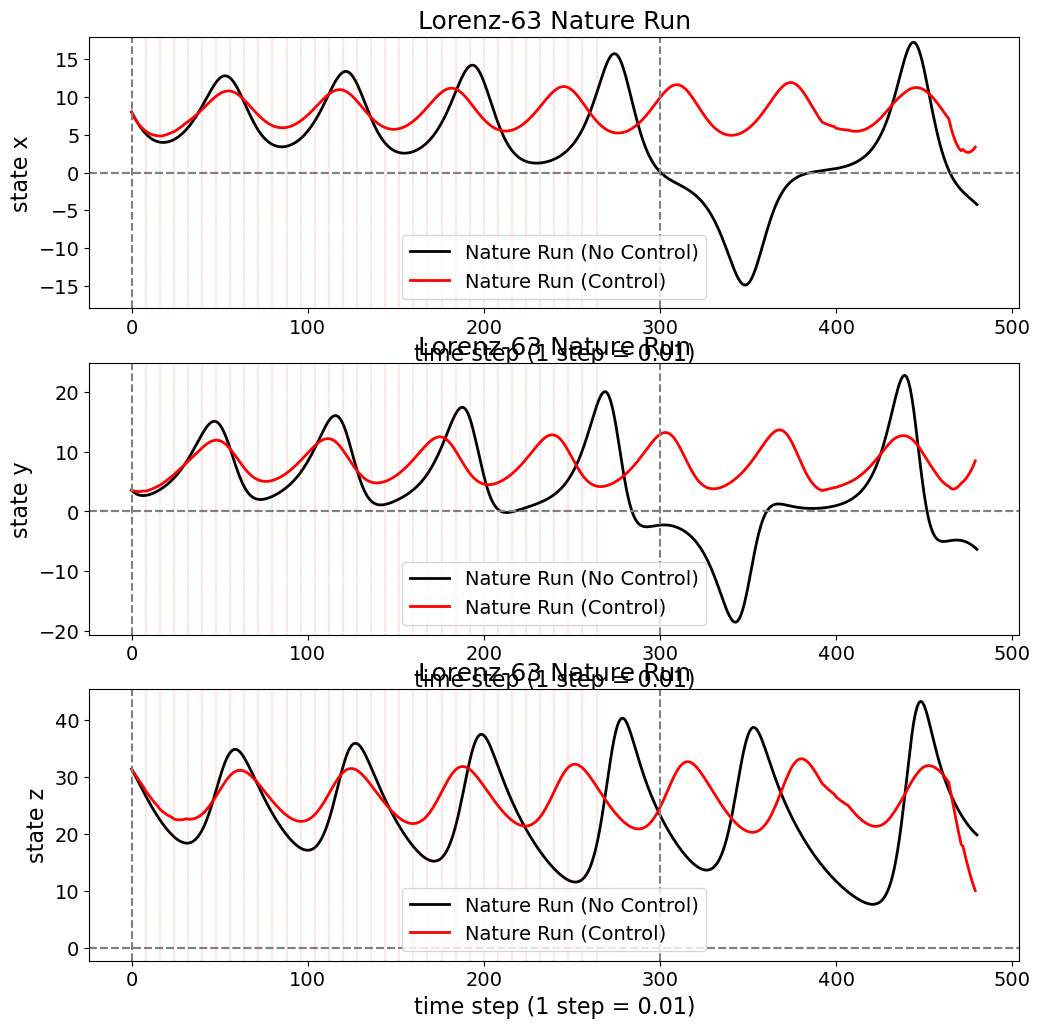

Plotting complete


In [20]:
fig = plt.figure(figsize = (12,12))
ax  = fig.add_subplot(311)
plt.plot(x_nature_nocontrol_3d[0,0:num_cycles*Ta+1], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'black', label="Nature Run (No Control)")
plt.plot(x_nature_control_3d[:,0], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'red', label="Nature Run (Control)")
plt.axhline(y = 0, linestyle='dashed', color = 'grey')   
plt.axhline(y = 0, linestyle='dashed', color = 'grey')
plt.axvline(x = 0, linestyle='dashed', color = 'grey')
for x in np.arange(8, 8*34, 8):
	plt.axvline(x=x, linestyle='dashed', linewidth=0.2, color='red')
plt.axvline(x = 300, linestyle='dashed', color = 'grey')
plt.xlabel('time step (1 step = 0.01)', fontsize = 16)
plt.ylabel('state x', fontsize = 16)
plt.title('Lorenz-63 Nature Run', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(-18,18)
#plt.xlim(-10,350)
ax.legend(fontsize=14)
#
ax  = fig.add_subplot(312)
plt.plot(x_nature_nocontrol_3d[1,0:num_cycles*Ta+1], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'black', label="Nature Run (No Control)")
plt.plot(x_nature_control_3d[:,1], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'red', label="Nature Run (Control)")
plt.axhline(y = 0, linestyle='dashed', color = 'grey')   
plt.axhline(y = 0, linestyle='dashed', color = 'grey')
plt.axvline(x = 0, linestyle='dashed', color = 'grey')
for x in np.arange(8, 8*34, 8):
	plt.axvline(x=x, linestyle='dashed', linewidth=0.2, color='red')
plt.axvline(x = 300, linestyle='dashed', color = 'grey')
plt.xlabel('time step (1 step = 0.01)', fontsize = 16)
plt.ylabel('state y', fontsize = 16)
plt.title('Lorenz-63 Nature Run', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(-18,18)
#plt.xlim(-10,350)
ax.legend(fontsize=14)
#
ax  = fig.add_subplot(313)
plt.plot(x_nature_nocontrol_3d[2,0:num_cycles*Ta+1], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'black', label="Nature Run (No Control)")
plt.plot(x_nature_control_3d[:,2], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'red', label="Nature Run (Control)")
plt.axhline(y = 0, linestyle='dashed', color = 'grey')   
plt.axhline(y = 0, linestyle='dashed', color = 'grey')
plt.axvline(x = 0, linestyle='dashed', color = 'grey')
for x in np.arange(8, 8*34, 8):
	plt.axvline(x=x, linestyle='dashed', linewidth=0.2, color='red')
plt.axvline(x = 300, linestyle='dashed', color = 'grey')
plt.xlabel('time step (1 step = 0.01)', fontsize = 16)
plt.ylabel('state z', fontsize = 16)
plt.title('Lorenz-63 Nature Run', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(-18,18)
#plt.xlim(-10,350)
ax.legend(fontsize=14)
plt.show()
#fig.savefig('Forecasts_Step2_Time_Step_'+str(t_index)+'.png', dpi=300, bbox_inches = 'tight')
plt.close(fig)
print('Plotting complete')

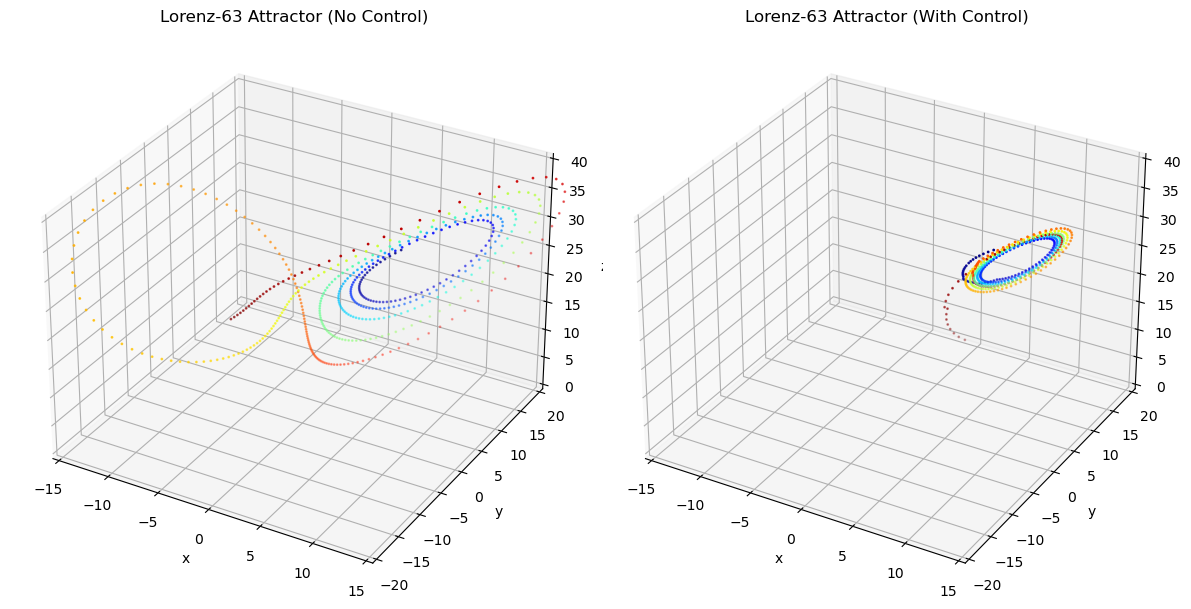

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12, 6))

# === Plot 1: No-Control ===
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(
    x_nature_nocontrol_3d[0, 0:num_cycles*Ta+1],
    x_nature_nocontrol_3d[1, 0:num_cycles*Ta+1],
    x_nature_nocontrol_3d[2, 0:num_cycles*Ta+1],
    c=np.linspace(0, 1, len(x_nature_nocontrol_3d[0, 0:num_cycles*Ta+1])),
    cmap='jet',
    s=1
)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Lorenz-63 Attractor (No Control)')
ax1.set_xlim(-15, 15)
ax1.set_ylim(-20, 20)
ax1.set_zlim(0, 40)
#ax1.view_init(elev=30, azim=45)

# === Plot 2: Control ===
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(
    x_nature_control_3d[:, 0],
    x_nature_control_3d[:, 1],
    x_nature_control_3d[:, 2],
    c=np.linspace(0, 1, np.shape(x_nature_control_3d)[0]),
    cmap='jet',
    s=1
)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('Lorenz-63 Attractor (With Control)')
ax2.set_xlim(-15, 15)
ax2.set_ylim(-20, 20)
ax2.set_zlim(0, 40)
#ax2.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


In [ ]:
np.linspace(0, 1, np.shape(x_nature_nocontrol_3d)[1])

array([0.00000000e+00, 3.57270454e-04, 7.14540907e-04, ...,
       9.99285459e-01, 9.99642730e-01, 1.00000000e+00])

In [ ]:
np.shape(x_nature_nocontrol_3d)[1]

2800

In [ ]:
len(x_nature_nocontrol_3d[0, 0:num_cycles*Ta+1])

713